In [49]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

In [50]:
print(torch.__version__)

2.3.0+cu118


In [51]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device:", device)

Using device: cuda


In [52]:
# create weight and bias
m = 0.7
c = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = m*X + c
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [53]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

In [54]:
X_train.shape, y_train.shape

(torch.Size([40, 1]), torch.Size([40, 1]))

In [55]:
def plot_data(
                training_X = X_train,
                training_y = y_train,
                testing_X = X_test,
                testing_y = y_test,
                predictions = None 
            ):
    plt.figure(figsize=(10,7))
    # Plot training data
    plt.scatter(training_X, training_y, c='b', s=4, label = "Training Data")
    # Plot testing data
    plt.scatter(testing_X, testing_y, c='g', s=4, label = "Testing Data")
    # Plot predictions if not None
    if predictions is not None:
       plt.scatter(testing_X, predictions, c='r', s=4, label = "Predicted Data") 

    plt.legend(prop={"size": 12});

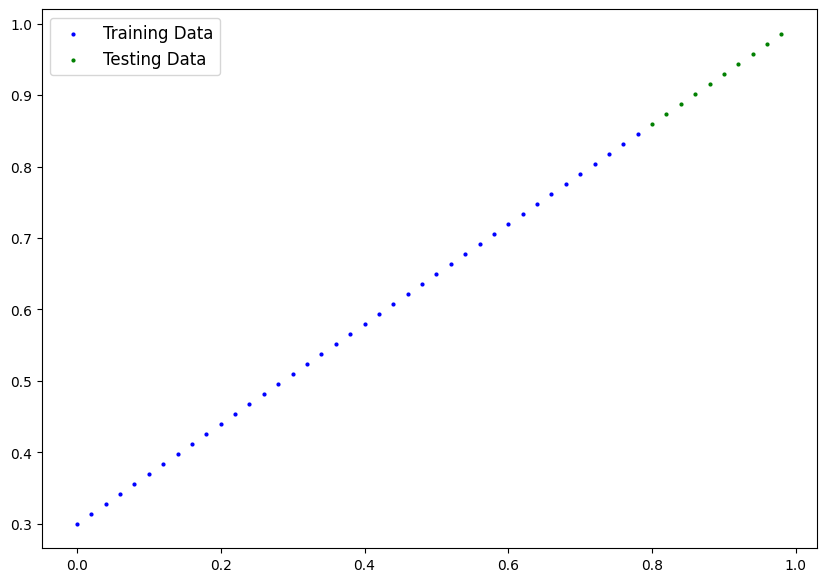

In [56]:
plot_data()

In [57]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, dtype=torch.float, requires_grad = True))
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float, requires_grad=True))

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias


In [58]:
torch.manual_seed(42)

model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [59]:
with torch.inference_mode():
    y_preds = model_0(X_test)

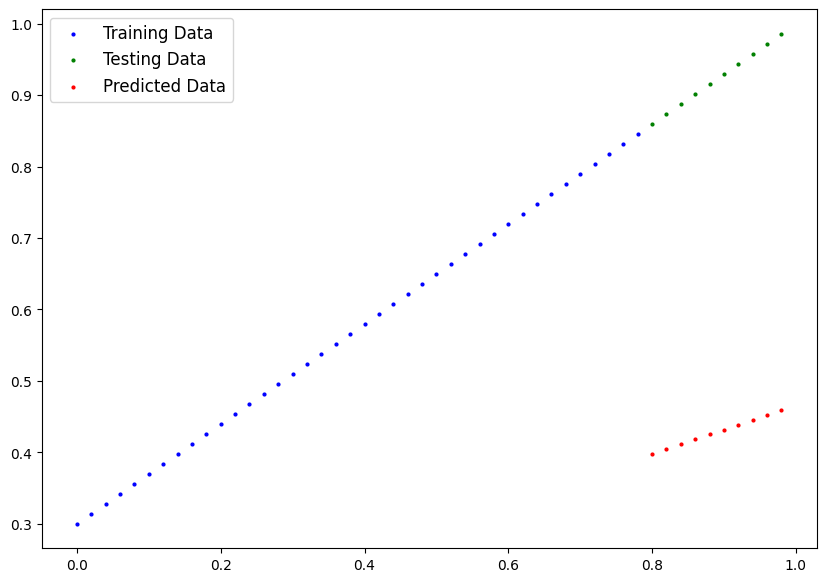

In [60]:
plot_data(predictions= y_preds)

In [62]:
# Set up loss function and optimizer
loss_fn = nn.MSELoss() # nn1.L1Los() -> MAE Loss

optimizer = torch.optim.SGD(params = model_0.parameters(),lr = 0.1)

In [63]:
model_0.to(device)
next(model_0.parameters()).device

device(type='cuda', index=0)

In [66]:
#set up training loop
torch.manual_seed(42)

epochs = 500
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
trainLossList = []
testLossList = []

for epoch in range(epochs):
    #training
    model_0.train()

    # 1. Forward Pass
    y_preds = model_0(X_train)

    # 2. Calculate Loss
    loss = loss_fn(y_train, y_preds)

    # 3. Zero Grad Optimizer
    optimizer.zero_grad()

    # 4. Loss Backward
    loss.backward()

    # 5. Step the Optimizer
    optimizer.step()

    ## Testing
    with torch.inference_mode():
        test_preds = model_0(X_test)

        test_loss = loss_fn(y_test, test_preds)

    if epoch%10 == 0:
        print(f"Epoch: {epoch} | Training Loss: {loss:.4f} | Test Loss : {test_loss:.4f}")

    trainLossList.append(loss.cpu().detach().numpy())
    testLossList.append(test_loss.cpu().detach().numpy())

Epoch: 0 | Training Loss: 0.0632 | Test Loss : 0.1153
Epoch: 10 | Training Loss: 0.0031 | Test Loss : 0.0156
Epoch: 20 | Training Loss: 0.0023 | Test Loss : 0.0101
Epoch: 30 | Training Loss: 0.0019 | Test Loss : 0.0082
Epoch: 40 | Training Loss: 0.0016 | Test Loss : 0.0068
Epoch: 50 | Training Loss: 0.0013 | Test Loss : 0.0057
Epoch: 60 | Training Loss: 0.0011 | Test Loss : 0.0047
Epoch: 70 | Training Loss: 0.0009 | Test Loss : 0.0039
Epoch: 80 | Training Loss: 0.0008 | Test Loss : 0.0033
Epoch: 90 | Training Loss: 0.0006 | Test Loss : 0.0027
Epoch: 100 | Training Loss: 0.0005 | Test Loss : 0.0023
Epoch: 110 | Training Loss: 0.0004 | Test Loss : 0.0019
Epoch: 120 | Training Loss: 0.0004 | Test Loss : 0.0016
Epoch: 130 | Training Loss: 0.0003 | Test Loss : 0.0013
Epoch: 140 | Training Loss: 0.0003 | Test Loss : 0.0011
Epoch: 150 | Training Loss: 0.0002 | Test Loss : 0.0009
Epoch: 160 | Training Loss: 0.0002 | Test Loss : 0.0007
Epoch: 170 | Training Loss: 0.0001 | Test Loss : 0.0006
Epo

In [67]:
# Let us make predictions
with torch.inference_mode():
    y_preds = model_0(X_test)

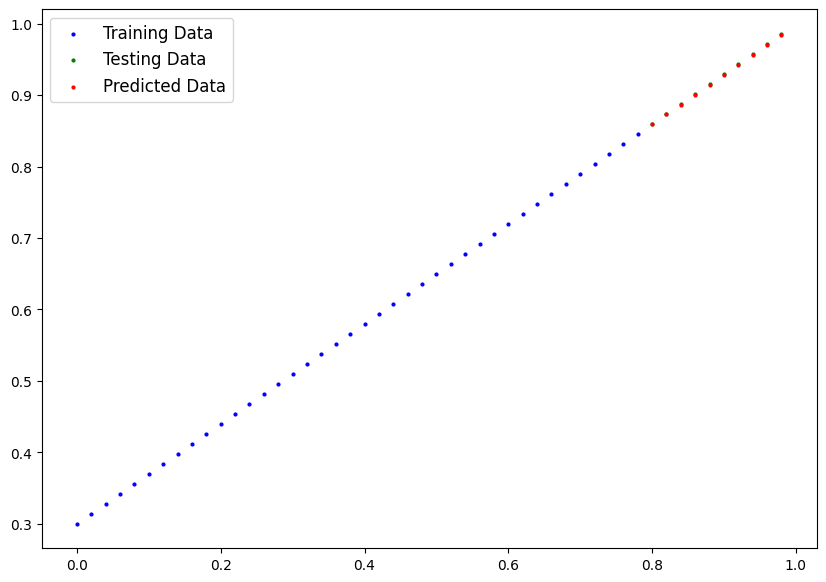

In [68]:
plot_data(predictions=y_preds.cpu().numpy())

In [69]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6975], device='cuda:0')),
             ('bias', tensor([0.3010], device='cuda:0'))])

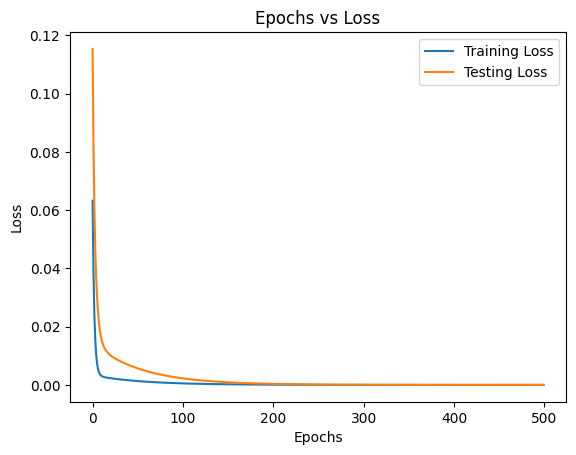

In [70]:
plt.plot(range(epochs),trainLossList,label="Training Loss")
plt.plot(range(epochs),testLossList,label="Testing Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epochs vs Loss")
plt.savefig('Loss.png')
plt.legend();

In [71]:
#### Saving a PyTorch Model

from pathlib import Path 

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "00_pytorch_linear_regression_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME 

# 3. Save the model state dict
print(f'Saving model to {MODEL_SAVE_PATH}')
torch.save(obj=model_0.state_dict(), f= MODEL_SAVE_PATH)

Saving model to models/00_pytorch_linear_regression_0.pth
